# タイタニック号

# 1. プロジェクト概要とハイライト

タイタニック号の生存者予測における**目的、最終的な成果、および分析を通じて得られた最大の知見**を要約している。

---

### 💡 挑戦と成果の要約（ハイライト）

| 項目 | 詳細 |
| :--- | :--- |
| **プロジェクト目的** | Kaggleタイタニックデータを用い、乗客の属性から生存を予測する**二値分類モデル**の構築。 |
| **最終結果** | Kaggle LBスコア **0.78468** を達成。 |
| **採用手法** | 汎化性能の最大化を目指した**スタッキング**（ベースモデル: XGBoost, RandomForest, LightGBM）。 |

#### 🚀 最大のインサイト（分析の核心）

> **「XGBoostとRandomForestの出力を統合したスタッキング手法」**の採用により、単一モデルの限界を超えた**汎化性能の向上（LBスコア +0.5%）**を実現。メタモデルの係数分析を通じ、データセットに最も適した**モデルの論理的な統合**が、精度向上の鍵であることを実証しました。

---

### 2. データ分析・モデリングの主要な論理構造

本プロジェクトの分析における、特に高度な技術的判断の背景を示します。

#### A. 欠損値分析における傾向スコアの活用

* **論理的仮説**: `Age`の欠損は**生存（`Survived`）**や**客室等級（`Pclass`）**と統計的に有意に関連する（**MAR: Missing At Random**）。
* **アクション**: 統計検定の結果に基づき、「`Age`が欠損しているかどうか」を示す**バイナリフラグ**を**欠損の傾向スコア**として特徴量に追加。
* **効果**: 欠損そのものが持つメタ情報（欠損傾向）をモデルに学習させることで、単なる補完ノイズの影響を抑え、予測力を向上させた。

#### B. モデルの評価とロバスト性への考察

* **課題の特定**: CVスコアとLBスコアの落差から、モデルに**過学習の傾向**がある、または**ロバスト性（頑健性）が不足**している可能性を示唆。
* **結論への展開**: この課題認識に基づき、結論部では、**正則化の強化**や**より多様なメカニズムを持つモデルのアンサンブル**を最優先の改善点として設定した。

### 基本情報
**〇プロジェクトの目的**<br>
kaggleタイタニックデータを用いて乗客の特徴から沈没時に生存か死亡かに分類するモデルを作成する。<br>
**〇使用したアルゴリズム**<br>
- ベースモデル（XGBoost,RM,LightGBM）
- アンサンブル学習（ロジスティック回帰,スタッキング）<br>
**〇最終結果**<br>
kaggleのLBスコア： 0.78468<br>

**〇最大のインサイト**<br>
XGBoostとRandomForestの出力を統合するスタッキング手法を採用し、単一モデルの限界を超えた汎化性能の向上（LBスコア +0.5%）を実現。<br>
単なるモデル構築に留まらず、モデルの貢献度を分析することで、このデータセットにおけるモデル選択の最適解を導出した。

#### 前処理

In [1]:
#必要なライブラリの読み込み
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

df = pd.read_csv('train.csv')
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

分類問題であるため、正解データのSurvived列にどういう種類のデータがあるか調べる

In [5]:
df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

不均衡データであることが分かる。<br>

In [7]:
#欠損値の処理を行う
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
df.shape

(891, 12)

`Cabin`列は891件に対して数が多すぎる。また、`Age`列も約20％程度であるため、欠損値はかなり多いといえる。<br>
欠損値処理として、平均値による欠損値補完や、欠損値の含まれた行をそのまま消してしまうなどが考えられるが、今回は、**欠損値が多いので、機械学習による欠損値補完を行い、予測精度を向上させることを試みる**。<br>
ただ、なぜ欠損値がこれほどまでに多いのかを考えたい。<br>
`Cabin`列は名称であるから、`Age`列についてなぜここまで欠損値が多いのか、調べつつ、必要であれば別途フラグ列を作成してから欠損値補完を行なうことを考えようと思う。

In [11]:
df_null_age = df[df['Age'].isnull()]
df_age = df[df['Age'].notnull()]

In [13]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

数値カラムとして扱われているが、実質カテゴリーデータであるもの（`Survived`,`Pclass`など）を統計検定を用いて、**欠損していること自体が生存に関わる情報かもしれない**ので、`Age`列の欠損があった行となかった行の間で統計的に有意な差があったのかどうか調べていく。欠損していること自体が生存に関わる情報であるとすれば、「`Age`が欠損しているかどうか」というフラグ自体が、モデルの予測力を高めるための新しい特徴量として利用できる。

In [15]:
#帰無仮説：欠損列と非欠損列に差がない
#対立仮説：欠損列と非欠損列に差がある

#有意水準1％としてフィッシャーの正確検定とカイ二乗検定を用いる
from scipy import stats

# Ageの欠損フラグを作成
df['Age_missing'] = df['Age'].isnull().astype(int)  # 1=欠損あり, 0=欠損なし

#Embarked列のダミー変数化
df['Embarked(C)'] = df['Embarked'].astype('category')

# クロス集計表（Age_missing × Survived）
ct_survived = pd.crosstab(df['Age_missing'], df['Survived'])
ct_sex = pd.crosstab(df['Age_missing'],df['Sex'])
ct_pclass = pd.crosstab(df['Age_missing'],df['Pclass'])
ct_embarked  = pd.crosstab(df['Age_missing'],df['Embarked(C)'])

odds_ratio, p1 = stats.fisher_exact(ct_survived)
odds_ratio, p2 = stats.fisher_exact(ct_sex)
V,p3,dof,expected = stats.chi2_contingency(ct_pclass)
V,p4,dof,expected = stats.chi2_contingency(ct_embarked)

print('survived p-value:',p1)
print('sex p-value',p2)
print('pclass p-value',p3)
print('embarked p-value',p4)

survived p-value: 0.005772265797361906
sex p-value 0.11355832590105067
pclass p-value 9.945340263413207e-11
embarked p-value 4.9505903973894276e-24


これを見ると、`Survived`列、`Pclass`列、`Embarked`列には統計的に有意な差がありそうだ。<br>
カテゴリデータに関して、なぜそのような差が生まれるのかを考察していく。ただ、Survived列は事後データであるため考察しても得られるものが少なそうだから、今回は`Pclass`列、`Embarked`列に絞っての考察を行う。

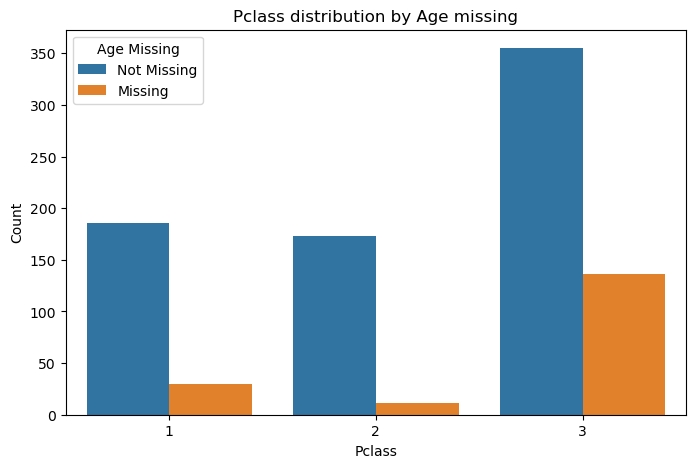

In [17]:
#Pclass列について
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Pclass", hue="Age_missing")

plt.title("Pclass distribution by Age missing")
plt.xlabel("Pclass")
plt.ylabel("Count")
plt.legend(title="Age Missing", labels=["Not Missing", "Missing"])
plt.show()

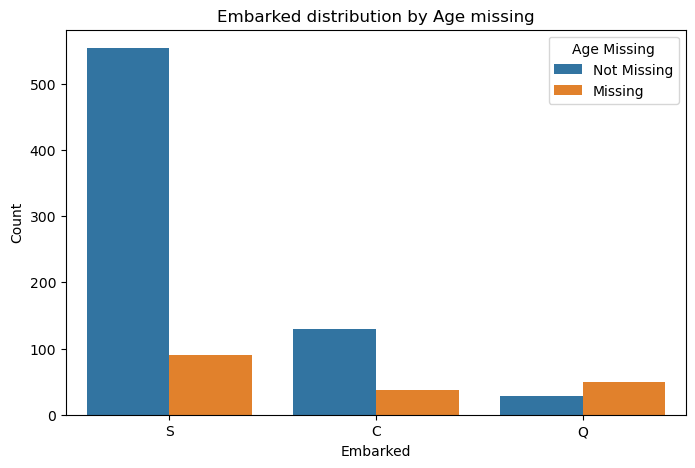

In [19]:
#Embarked列について
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Embarked", hue="Age_missing")

plt.title("Embarked distribution by Age missing")
plt.xlabel("Embarked")
plt.ylabel("Count")
plt.legend(title="Age Missing", labels=["Not Missing", "Missing"])
plt.show()

ここで、**なぜこのような不均衡が生じたのか**理由を考えてみると

**〇記録上の問題（非人為的）：**
<br><br>
当時、チケット購入や乗船名簿の管理が厳密ではなかった。
特に 3等客室（移民が多い）では、年齢を正確に記録していないことが多かった。
子どもや若者の場合、親の申告だけで「だいたい◯歳」とされるケースも多い。
<br><br><br>
**〇社会的背景（半人為的）：**
<br><br>
年齢がわからない／記録されないのは、社会階層による「情報の非対称性」かもしれない。
富裕層（1等・2等）は戸籍やパスポート情報が整備されているが、貧困層（3等）は年齢や身分の確認が曖昧。
<br><br>

これを踏まえて、欠損値処理を行いたい。

欠損値補完は傾向スコアを特徴量として追加したうえで、機械学習により柔軟に補完していく。<br>
傾向スコアを特徴量として加えることで、欠損値になりうる確率も考慮した補完が行える。また、単純に平均値で補完せず、機械学習によって補完することで、平均値よりも精度の高い欠損値補完ができる。<br><br>
機械学習手法として、
- 非線形・相互作用を自然に扱える
- 外れ値に強い
- ハイパーパラメータ調整が容易
<br><br>

という理由から、XGBoostを用いる。

In [25]:
#傾向スコア推定
from sklearn.linear_model import LogisticRegression


features = ['Pclass','Sex','Fare','Embarked','SibSp','Parch']
X_missing = pd.get_dummies(df[features], drop_first=True)
y_missing = df['Age_missing']


ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X_missing, y_missing)

df['pscore'] = ps_model.predict_proba(X_missing)[:,1]

In [30]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 1. 特徴量に傾向スコアを追加
features = ['Pclass','Sex','Fare','Embarked','SibSp','Parch']
X_rf = pd.get_dummies(df[features], drop_first=True)
X_rf['pscore'] = df['pscore']

# 欠損値の有無
mask_missing = df['Age_missing'] == 1
mask_present = df['Age_missing'] == 0

# 2. 欠損していないデータでモデル学習
X_train_age = X_rf[mask_present]
y_train_age = df.loc[mask_present, 'Age']

# 3. 欠損しているデータで予測
X_pred_age = X_rf[mask_missing]

# 4. XGBoost回帰モデル
age_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
)

age_model.fit(X_train_age, y_train_age)

# 5. 補完
df.loc[mask_missing, 'Age_imputed'] = age_model.predict(X_pred_age)

# 6. 確認
print(df[['Age', 'Age_imputed', 'Age_missing']].head(10))


    Age  Age_imputed  Age_missing
0  22.0          NaN            0
1  38.0          NaN            0
2  26.0          NaN            0
3  35.0          NaN            0
4  35.0          NaN            0
5   NaN    31.978672            1
6  54.0          NaN            0
7   2.0          NaN            0
8  27.0          NaN            0
9  14.0          NaN            0


In [32]:
#最終補完列を作る
df['Age_filled'] = df['Age']
df.loc[df['Age_missing'] == 1, 'Age_filled'] = df.loc[df['Age_missing'] == 1, 'Age_imputed']

#### 特徴量エンジニアリングを行う

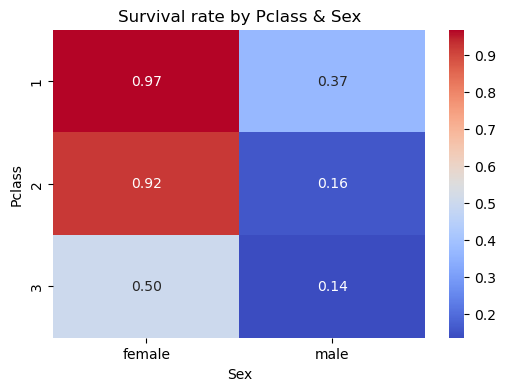

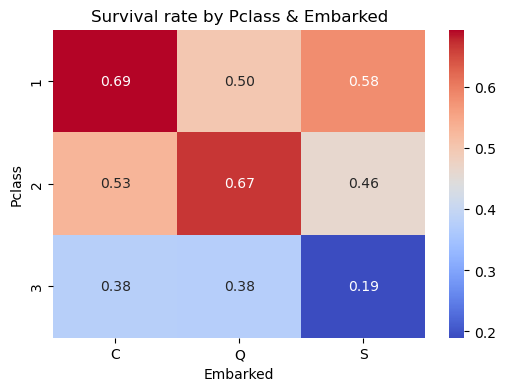

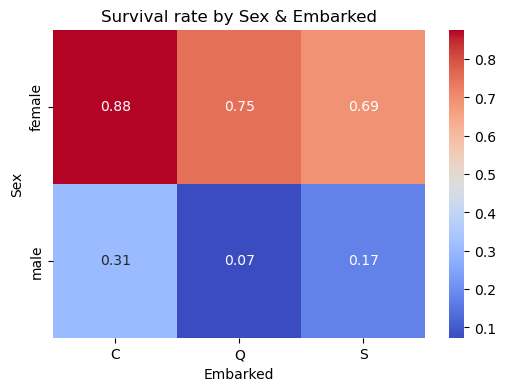

In [37]:
#まず、カテゴリ変数の全ペア交互作用可視化を行う。
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

cat_cols = ['Pclass', 'Sex', 'Embarked']  # カテゴリ変数
for col1, col2 in itertools.combinations(cat_cols, 2):
    ct = df.pivot_table(index=col1, columns=col2, values='Survived', aggfunc='mean')
    plt.figure(figsize=(6,4))
    sns.heatmap(ct, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f'Survival rate by {col1} & {col2}')
    plt.show()

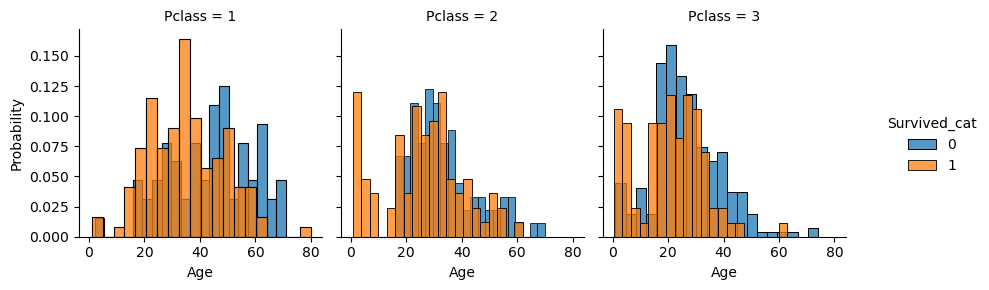

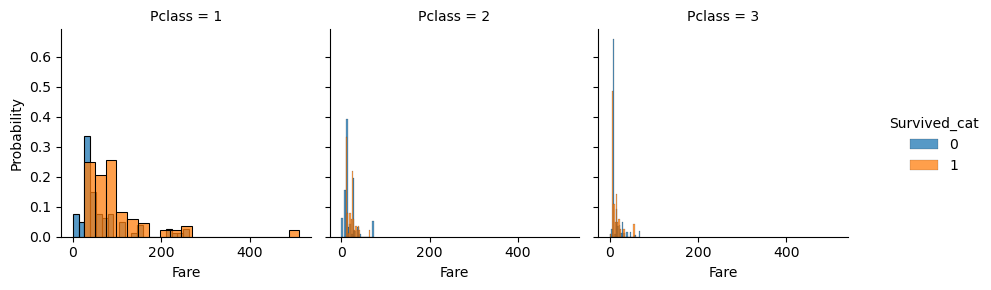

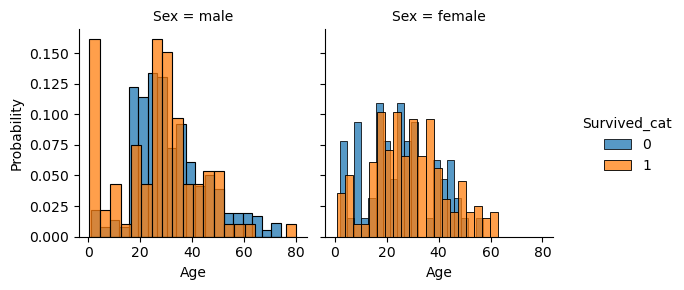

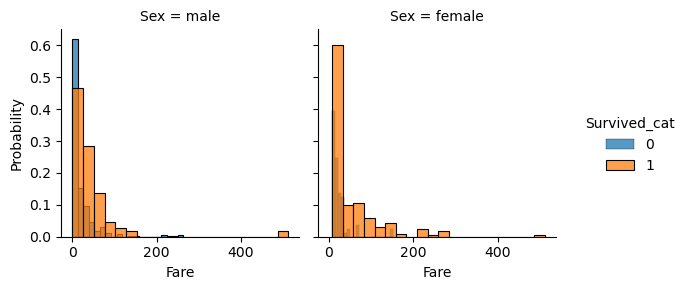

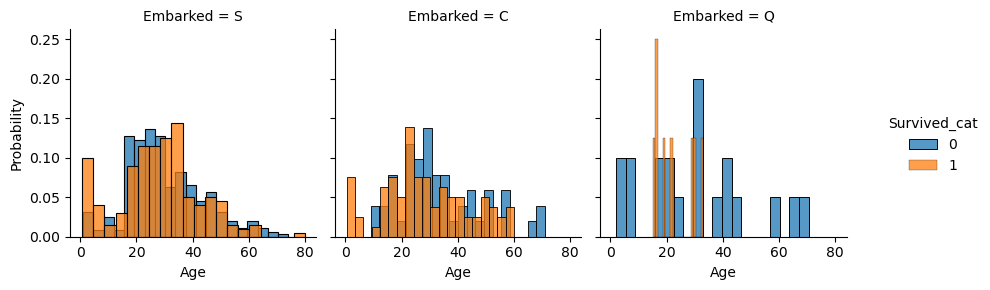

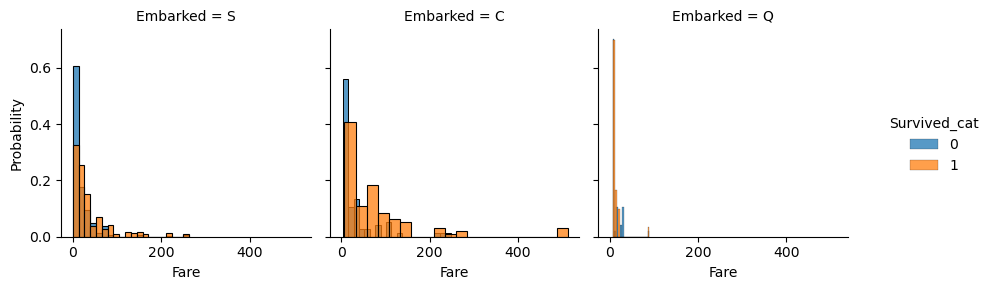

In [51]:
num_cols = ['Age', 'Fare']
cat_cols = ['Pclass', 'Sex', 'Embarked']

df['Survived_cat'] = df['Survived'].astype('category')

for cat_col in cat_cols:
    for num_col in num_cols:
        g = sns.FacetGrid(df, col=cat_col, hue='Survived_cat', margin_titles=True)
        
        # こっちなら map ではなく map_dataframe を使う
        g.map_dataframe(sns.histplot, x=num_col, bins=20, stat='probability')
        
        g.add_legend()
        plt.show()

In [57]:
df['Sex'] = pd.get_dummies(df['Sex'],drop_first=True)
# Sex × Age
df['Sex_Age'] = df['Sex'] * df['Age_filled']  # Sexをダミー化済みと仮定

# Pclass × Fare
df['Pclass_Fare'] = df['Pclass'] * df['Fare']

数値データの分布を調べる。<br>
正規分布でないデータがあれば、エンジニアリングで正規分布に近づける。

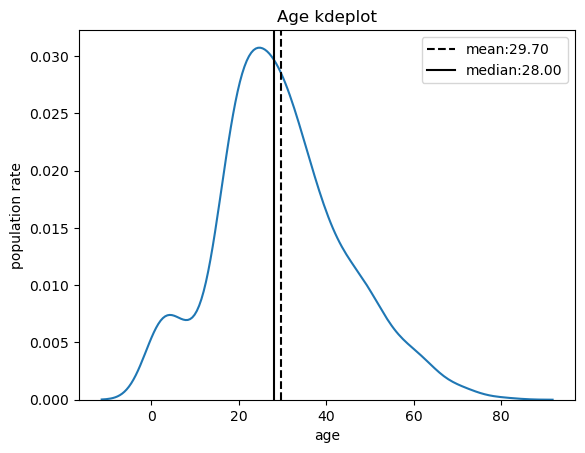

In [61]:
#Age
sns.kdeplot(df['Age'])
plt.xlabel('age')
plt.ylabel('population rate')
plt.title('Age kdeplot')
plt.axvline(df['Age'].mean(),color='black',linestyle='--',label=f'mean:{df['Age'].mean():.2f}') 
plt.axvline(df['Age'].median(),color='black',linestyle='-',label=f'median:{df['Age'].median():.2f}')

plt.legend()
plt.show()

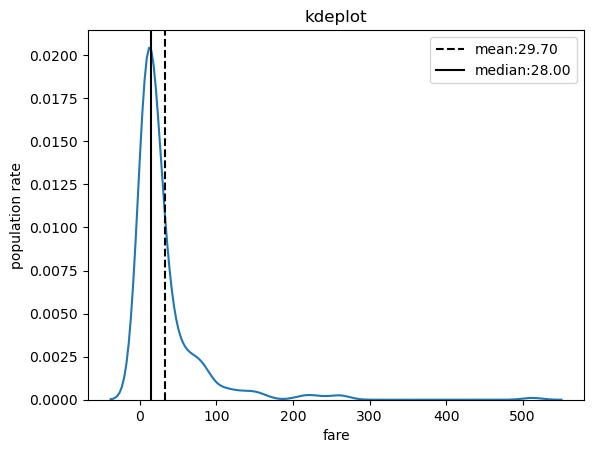

In [63]:
#Fare
sns.kdeplot(df['Fare'])
plt.xlabel('fare')
plt.ylabel('population rate')
plt.title('kdeplot')
plt.axvline(df['Fare'].mean(),color='black',linestyle='--',label=f'mean:{df['Age'].mean():.2f}') 
plt.axvline(df['Fare'].median(),color='black',linestyle='-',label=f'median:{df['Age'].median():.2f}')

plt.legend()
plt.show()

`Age`列や`Fare`列は、右に裾が長いので、正規分布に近づけるために対数をとる

In [71]:
df['Fare_log'] = np.log1p(df['Fare'])
df['Age_log'] = np.log1p(df['Age_filled'])

家族の人数によって、生存率が変化しているか調べる。

In [75]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df.groupby('FamilySize')['Survived'].mean()

FamilySize
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64

差がありそうだから、`FamilySize`も特徴量に加えて、予測精度を見てみる。

これまでで生成した特徴量を用いて、予測していく。

#### モデル学習

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# -------------------------------
# 1. データ読み込み
# -------------------------------
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# train/test 区別用
train["is_train"] = 1
test["is_train"] = 0

# Survived は test には無いので仮で追加
test["Survived"] = np.nan  

# 一つにまとめる
df = pd.concat([train, test], ignore_index=True)

# -------------------------------
# 2. 欠損値処理（Fare, Embarked）
# -------------------------------
# Fare → median
df["Fare"] = df["Fare"].fillna(df["Fare"].median())

# Embarked → mode
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# -------------------------------
# 3. Age 補完のための傾向スコア
# -------------------------------
df["Age_missing"] = df["Age"].isnull().astype(int)

features = ['Pclass','Sex','Fare','Embarked','SibSp','Parch']
X_missing = pd.get_dummies(df[features], drop_first=True)
y_missing = df['Age_missing']

# 傾向スコア推定
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X_missing, y_missing)
df['pscore'] = ps_model.predict_proba(X_missing)[:,1]

# XGBoost で Age を予測補完
X_rf = pd.get_dummies(df[features], drop_first=True)
X_rf["pscore"] = df["pscore"]

mask_missing = df["Age_missing"] == 1
mask_present = df["Age_missing"] == 0

X_train_age = X_rf[mask_present]
y_train_age = df.loc[mask_present, "Age"]

X_pred_age = X_rf[mask_missing]

age_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
)
age_model.fit(X_train_age, y_train_age)

df.loc[mask_missing, "Age"] = age_model.predict(X_pred_age)

# -------------------------------
# 4. 特徴量作成
# -------------------------------
df["Age_log"] = np.log1p(df["Age"])
df["Fare_log"] = np.log1p(df["Fare"])
df["Sex_Age"] = df["Age"] * df["Sex"].map({"male":1,"female":0})
df["Pclass_Fare"] = df["Pclass"] * df["Fare"]
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

# One-hot encoding
df = pd.get_dummies(df, columns=["Sex","Embarked"], drop_first=True)

# -------------------------------
# 5. train/test に分け直し
# -------------------------------
train = df[df["is_train"] == 1].drop(columns=["is_train"])
test = df[df["is_train"] == 0].drop(columns=["is_train","Survived"])

X_train = train.drop(columns=["PassengerId","Survived","Name","Ticket","Cabin"])
y_train = train["Survived"].astype(int)

X_test = test.drop(columns=["PassengerId","Name","Ticket","Cabin"])

# -------------------------------
# 6. モデル学習 & Cross-Validation
# -------------------------------
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.05,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=make_scorer(roc_auc_score))

print("CV AUC:", scores.mean())

# -------------------------------
# 7. 学習 & 予測
# -------------------------------
model.fit(X_train, y_train)
pred_test = model.predict(X_test)

C:\Users\kinou\anaconda3_\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:20:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\kinou\anaconda3_\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:20:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\kinou\anaconda3_\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:20:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\kinou\anaconda3_\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:20:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update

CV AUC: 0.81890498404823


C:\Users\kinou\anaconda3_\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:20:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


まず、XGBoostのハイパーパラメーターチューニングで、予測精度を上げていく。

In [89]:
! pip install optuna

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0


In [12]:
import optuna

def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "auc"
    }
    model = xgb.XGBClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best params:", study.best_params)
print("Best CV AUC:", study.best_value)

[I 2025-09-26 12:20:12,389] A new study created in memory with name: no-name-3758db64-e9f8-4ce4-9e89-d54ab92a9a87
C:\Users\kinou\AppData\Local\Temp\ipykernel_24852\376044392.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
C:\Users\kinou\AppData\Local\Temp\ipykernel_24852\376044392.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
C:\Users\kinou\AppData\Local\Temp\ipykernel_24852\376044392.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

Best params: {'n_estimators': 792, 'max_depth': 4, 'learning_rate': 0.011364432686338775, 'subsample': 0.6181906231038216, 'colsample_bytree': 0.7467453579394717}
Best CV AUC: 0.8769887150204028


In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score

# -------------------------
# 1. モデル定義（Optunaで得たベストパラメータを適用）
# -------------------------
best_params = {
    'n_estimators': 680,
    'max_depth': 4,
    'learning_rate': 0.022031201583846867,
    'subsample': 0.6732706309782529,
    'colsample_bytree': 0.8094390330556389,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': "auc"
}

model = xgb.XGBClassifier(**best_params)

# -------------------------
# 2. クロスバリデーション（CV AUC 確認）
# -------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=make_scorer(roc_auc_score))
print("CV AUC:", scores.mean())

# -------------------------
# 3. 学習
# -------------------------
model.fit(X_train, y_train)

# -------------------------
# 4. 検証スコア確認
# -------------------------
y_pred_train = model.predict(X_train)
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))

# -------------------------
# 5. テストデータ予測
# -------------------------
y_pred_test = model.predict(X_test)

C:\Users\kinou\anaconda3_\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:49:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\kinou\anaconda3_\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:49:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\kinou\anaconda3_\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:49:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\kinou\anaconda3_\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:49:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update

CV AUC: 0.8201357233613974


C:\Users\kinou\anaconda3_\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:49:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Accuracy: 0.9259259259259259


過学習してしまったので、L1,L2を正規化し、ノード分割を抑制してみる。

In [13]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

# モデル定義（Optunaの結果をベースに正則化を追加）
model = xgb.XGBClassifier(
    n_estimators=658,
    max_depth=5,
    learning_rate=0.0134,
    subsample=0.704,
    colsample_bytree=0.956,
    reg_alpha=1.0,      # L1 正則化（デフォルト0）
    reg_lambda=2.0,     # L2 正則化（デフォルト1）
    min_child_weight=5, # ノード分割を抑制
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

# クロスバリデーション
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=make_scorer(roc_auc_score))

print("CV AUC:", scores.mean())


C:\Users\kinou\anaconda3_\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:21:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\kinou\anaconda3_\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:21:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\kinou\anaconda3_\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:21:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\kinou\anaconda3_\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:21:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update

CV AUC: 0.8199305651839733


以下の条件を付けくわえながら再度予測してみる。

In [10]:
# 必要ライブラリ
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
import optuna

# (前提) X_train, y_train, X_test が既に前処理済みで揃っていること
# （欠損補完、one-hotなどの前処理はここで完了している想定）

# 1) 共通のCVを定義（これをOptuna と最終評価で共有）
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2) Optuna 用の objective（cv を明示的に使う）
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.2),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
        # 正則化の候補も含めると良い
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "auc",
        # n_jobs を入れると cross_val_score の中で並列が使える（環境依存）
    }

    # sklearn API のラッパー
    model = xgb.XGBClassifier(
        n_estimators=int(params["n_estimators"]),
        max_depth=int(params["max_depth"]),
        learning_rate=params["learning_rate"],
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        reg_alpha=params["reg_alpha"],
        reg_lambda=params["reg_lambda"],
        min_child_weight=params["min_child_weight"],
        random_state=42,
        use_label_encoder=False,
        eval_metric="auc",
        n_jobs=-1,
        verbosity=0
    )

    # ここで必ず同じ cv と scoring('roc_auc') を使う
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    return scores.mean()

# 3) Optuna 実行（例：30~50 trial）
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best params:", study.best_params)
print("Best CV AUC (Optuna):", study.best_value)

# 4) Optuna の best params を取り出して xgb.cv で適切な n_estimators を決める
best = study.best_params

xgb_params_for_cv = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": int(best["max_depth"]),
    "eta": best["learning_rate"],  # xgb.cv は eta を使う
    "subsample": best["subsample"],
    "colsample_bytree": best["colsample_bytree"],
    "alpha": best["reg_alpha"],
    "lambda": best["reg_lambda"],
    "min_child_weight": best["min_child_weight"],
    "seed": 42,
    "verbosity": 0
}

dtrain = xgb.DMatrix(X_train, label=y_train)

cv_results = xgb.cv(
    params=xgb_params_for_cv,
    dtrain=dtrain,
    num_boost_round=1500,            # 大きめに指定して early_stopping に任せる
    nfold=5,
    metrics=("auc",),
    seed=42,
    stratified=True,
    early_stopping_rounds=50,
    as_pandas=True,
    verbose_eval=False
)

best_nrounds = len(cv_results)
print("best_nrounds (from xgb.cv):", best_nrounds)
print(cv_results.tail())

# 5) 最終モデル学習（決定した n_estimators を使う）
final_model = xgb.XGBClassifier(
    n_estimators=best_nrounds,
    max_depth=int(best["max_depth"]),
    learning_rate=best["learning_rate"],
    subsample=best["subsample"],
    colsample_bytree=best["colsample_bytree"],
    reg_alpha=best["reg_alpha"],
    reg_lambda=best["reg_lambda"],
    min_child_weight=best["min_child_weight"],
    random_state=42,
    use_label_encoder=False,
    eval_metric="auc",
    n_jobs=-1,
    verbosity=0
)

# 最終CVで評価（同じ cv を使う）
final_scores = cross_val_score(final_model, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
print("Final model CV AUC:", final_scores.mean(), final_scores)

# 学習してテスト予測
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)


[I 2025-09-26 07:53:55,785] A new study created in memory with name: no-name-f050d207-a23c-48f0-9718-0bc64771159b
C:\Users\kinou\AppData\Local\Temp\ipykernel_28444\840365093.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.2),
C:\Users\kinou\AppData\Local\Temp\ipykernel_28444\840365093.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
C:\Users\kinou\AppData\Local\Temp\ipykernel_28444\840365093.py:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0

Best params: {'n_estimators': 708, 'max_depth': 6, 'learning_rate': 0.046665715789890046, 'subsample': 0.9320342520795493, 'colsample_bytree': 0.92968077319566, 'reg_alpha': 5.714421026759424e-06, 'reg_lambda': 1.9993048934889779, 'min_child_weight': 9}
Best CV AUC (Optuna): 0.8867647947600551
best_nrounds (from xgb.cv): 275
     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
270        0.948108       0.002612       0.886708      0.025200
271        0.948233       0.002600       0.886682      0.024969
272        0.948300       0.002609       0.887082      0.024882
273        0.948419       0.002589       0.887135      0.025062
274        0.948519       0.002555       0.887242      0.024830
Final model CV AUC: 0.8858728892434516 [0.91627141 0.88181818 0.84244652 0.8848262  0.90400213]


In [12]:
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": y_test_pred
})

submission.to_csv("submission.csv", index=False)
print("submission.csv を出力しました")

submission.csv を出力しました


提出してみると、スコアは78％であった。<br>
汎化性能がまだ甘い汎化性能がまだ甘い。バイアス・バリアンスの影響でスコアが低いのかもしれない。もう少しスコアを向上させるために、スタッキングを行う。

In [16]:
! pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 8.5 MB/s eta 0:00:00


In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

# -------------------------
# 1. モデル定義
# -------------------------
xgb_model = final_model
lgb_model = LGBMClassifier(random_state=42, n_estimators=500)
rf_model  = RandomForestClassifier(random_state=42, n_estimators=500)

base_models = [xgb_model, lgb_model, rf_model]
meta_model  = LogisticRegression(max_iter=1000)

# -------------------------
# 2. OOF 予測作成
# -------------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros((X_train.shape[0], len(base_models)))
test_preds = np.zeros((X_test.shape[0], len(base_models)))

for i, model in enumerate(base_models):
    oof = np.zeros(X_train.shape[0])
    test_fold_preds = np.zeros((X_test.shape[0], kf.n_splits))
    
    for j, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        oof[val_idx] = model.predict_proba(X_val)[:, 1]
        test_fold_preds[:, j] = model.predict_proba(X_test)[:, 1]
    
    oof_preds[:, i] = oof
    test_preds[:, i] = test_fold_preds.mean(axis=1)

# -------------------------
# 3. メタモデル学習
# -------------------------
meta_model.fit(oof_preds, y_train)

# 最終予測
final_preds = meta_model.predict(test_preds)

# -------------------------
# 4. 提出ファイル作成
# -------------------------
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": final_preds
})
submission.to_csv("submission_stacking.csv", index=False)
print("submission_stacking.csv を出力しました")


C:\Users\kinou\anaconda3_\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 指定されたファイルが見つかりません。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\kinou\anaconda3_\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\kinou\anaconda3_\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kinou\anaconda3_\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\kinou\anaconda3_\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, a

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

予測精度は0.6%向上。<br>
テストデータはデータ数が少ないため、これ以上上げるのは難しい。<br>
そのため、ここで切り上げようと思う。<br>
**最後に特徴量重要度を調べる**

- XGB / LGBM / RF のどの元特徴量が効いているか
- ロジスティック回帰のどのベースモデルの予測に依存しているか

<br><br>
の二段階で評価する。

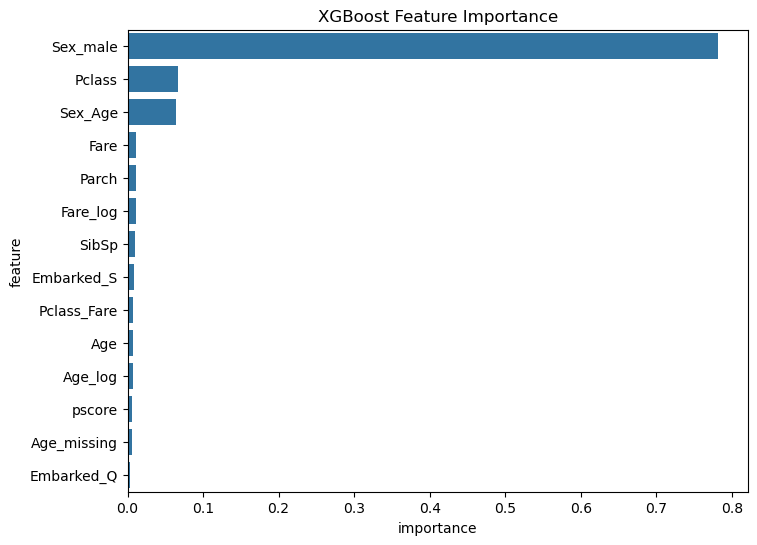

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

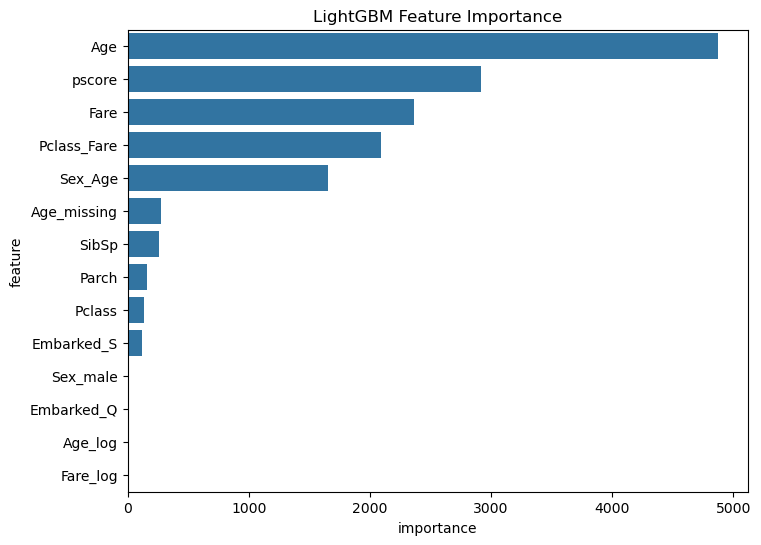

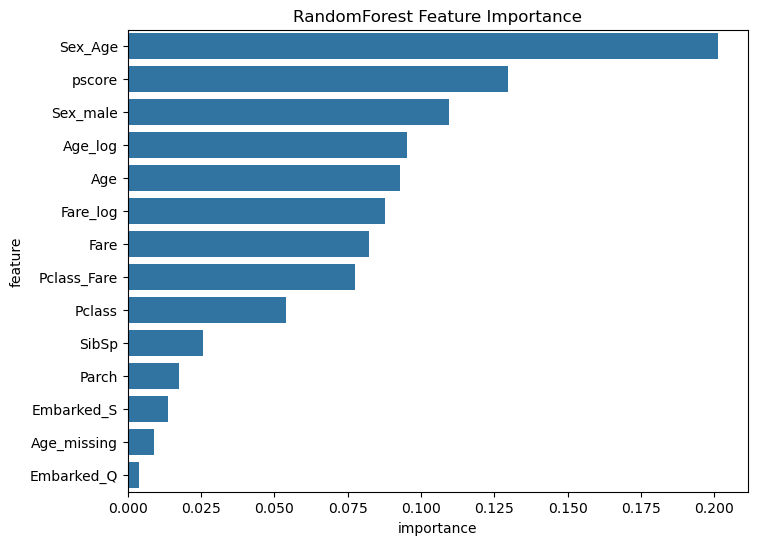

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost
xgb_model.fit(X_train, y_train)
xgb_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": xgb_model.feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=xgb_importance.head(15), x="importance", y="feature")
plt.title("XGBoost Feature Importance")
plt.show()

# LightGBM
lgb_model.fit(X_train, y_train)
lgb_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": lgb_model.feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=lgb_importance.head(15), x="importance", y="feature")
plt.title("LightGBM Feature Importance")
plt.show()

# RandomForest
rf_model.fit(X_train, y_train)
rf_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=rf_importance.head(15), x="importance", y="feature")
plt.title("RandomForest Feature Importance")
plt.show()


In [26]:
meta_coef = pd.DataFrame({
    "base_model": ["XGBoost", "LightGBM", "RandomForest"],
    "coef": meta_model.coef_[0]
}).sort_values(by="coef", ascending=False)

print(meta_coef)


     base_model      coef
0       XGBoost  3.149177
2  RandomForest  2.015317
1      LightGBM  0.112163


## 結論と展望

### 1. 最終的な考察と成果<br>
本プロジェクトの目的は、タイタニック号の乗客データに基づき、生存者を予測する二値分類モデルを構築することだった。<br>

**成果:**
<br><br>
複数のモデルを組み合わせたスタッキング手法により、単一のモデル（XGBoost, LightGBM, RandomForest）の予測結果のばらつきを抑え、より安定した**汎化性能の改善（LBスコアが +0.5% 向上）**を実現した。

**重要な知見:**
<br><br>
スタッキングのメタモデル（ロジスティック回帰）の係数分析から、XGBoostが最も予測に強く貢献していることが判明しました（係数: 3.15）。これは、XGBoostがタイタニックデータの特徴量を捉える上で最も適していたことを示唆する。

LightGBMの寄与度が低かった（係数: 0.11）ことから、使用したハイパーパラメータ設定では、XGBoostやRandomForestが捉えきれない、独自のパターンを見つけることができなかったと結論付けられる。

**課題:**
<br><br>
CV（交差検証）スコアとLB（リーダーボード）スコアに落差が生じたことから、モデルに過学習の傾向があるか、もしくはデータセット間のわずかな分布の差（データリーケージの可能性も含む）にモデルが過敏に反応した可能性が示唆される。
<br><br><br>

### 2. 今後の改善点とアクションプラン<br>
今回の結果に基づき、モデルのロバスト性（頑健性）と精度のさらなる向上を目指し、以下の改善を計画し、他データにも応用できるアクションを提案したい。<br>

**A. モデルのロバスト性向上（過学習対策）**
<br>
正則化の強化:
<br><br>
XGBoostやLightGBMに対し、$\lambda$ (L2正則化項)や$\alpha$ (L1正則化項)などの正則化パラメータを積極的に調整し、過学習を抑制することで、CVとLBスコアの乖離を是正することを目指すこと。
<br>
より多様なアンサンブル:
<br><br>
スタッキングに使用するベースモデルに、ニューラルネットワーク（Keras/TensorFlow）やサポートベクターマシン（SVM）など、異なるメカニズムを持つモデルを追加し、予測の多様性を高めることで、汎化性能の限界を追求したい。
<br>
**B. 特徴量エンジニアリングの深化**<br>
ドメイン知識の活用:
<br><br>
タイタニック号の乗客名簿から抽出した「Title（敬称）」の特徴量に対し、「Fare（運賃）」との関連性を分析するなど、複数の特徴量を組み合わせた新しい交互作用特徴量を作成し、モデルの解釈力を高められる。